In [1]:
# !pip install transformers torch

In [2]:

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
data = r"dataset2.csv"

df = pd.read_csv(data)
print(df.head())

                                                link  \
0  https://www.infowars.com/posts/the-wall-is-rea...   
1  https://www.infowars.com/posts/post-vaccinatio...   
2  https://www.infowars.com/posts/half-of-all-wom...   
3  https://www.infowars.com/posts/high-levels-of-...   
4  https://www.infowars.com/posts/epidemiologist-...   

                                               title  annotation  \
0  The Wall Is Real: Half of All Thirty-Something...           0   
1  “Post-Vaccination Syndrome:” New Paper Identif...           0   
2  Half of All Women in US Aged 30-35 Experiencin...           0   
3  High Levels of Microplastics Found in Lungs of...           0   
4  Epidemiologist Reveals New Data Linking Covid ...           0   

                                             content  
0  It’s a staple of the so-called “manosphere”—th...  
1  A new condition called “post-vaccination syndr...  
2  Half of all women in their 30s are now reporti...  
3  The lungs of birds contain sign

In [7]:
import string
string.punctuation

# Checks the contents if there are empty or missing values

# Get indices of rows with NaN or empty content
uncleanContents = df[df['content'].isna() | (df['content'].str.strip() == '')].index

# Print the missing/empty indices
print(f'Indices with missing or empty content: {uncleanContents}')

# Drop rows with NaN or empty content
df.drop(uncleanContents, inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

print(f"First file rows: {len(df)}")

Indices with missing or empty content: Index([  58,  185,  203,  210,  274,  289, 2018, 2019, 2020, 2021, 3254, 3301,
       3313, 3321, 3328, 3351, 4115, 4116, 4141, 4154, 4992],
      dtype='int64')
First file rows: 5763


In [8]:
# Assuming 'content' is the text column and 'annotation' is the label column
texts = df['content'].tolist()
labels = df['annotation'].tolist()

# Split the data into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', timeout=60)

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Convert to PyTorch datasets
train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']),
                              torch.tensor(train_encodings['attention_mask']),
                              torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']),
                            torch.tensor(val_encodings['attention_mask']),
                            torch.tensor(val_labels))

Token indices sequence length is longer than the specified maximum sequence length for this model (1375 > 512). Running this sequence through the model will result in indexing errors


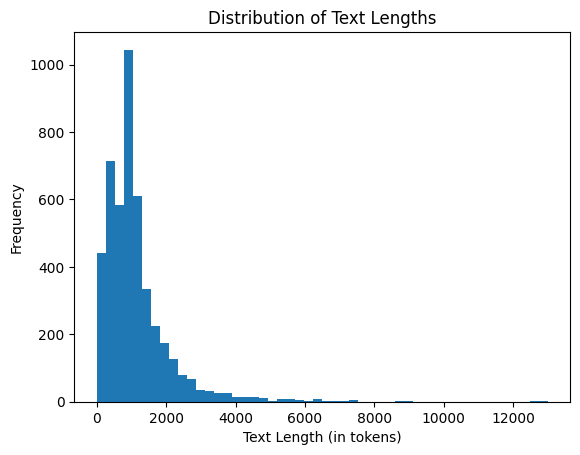

In [9]:
text_lengths = [len(tokenizer.encode(text)) for text in train_texts]

# Plot the distribution
import matplotlib.pyplot as plt
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length (in tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()

In [10]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(2):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

c:\Python312\Lib\site-packages\transformers\optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))

Accuracy: 0.9928443649373881
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       278
           1       1.00      0.99      0.99       281

    accuracy                           0.99       559
   macro avg       0.99      0.99      0.99       559
weighted avg       0.99      0.99      0.99       559



In [ ]:
model.save_pretrained('./distilbert_model2')
tokenizer.save_pretrained('./distilbert_model2')

('./distilbert_model\\tokenizer_config.json',
 './distilbert_model\\special_tokens_map.json',
 './distilbert_model\\vocab.txt',
 './distilbert_model\\added_tokens.json')